In [1]:
import os  
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from ta.momentum import RSIIndicator

In [3]:
# Load BTC data
df = pd.read_csv('btc_3m.csv', parse_dates=['datetime'], dayfirst=True)
df = df.set_index('datetime')

# Feature engineering
df['High_Low_Diff'] = df['high'] - df['low']
df['High_Low_Ratio'] = df['high'] / df['low']
df['Relative_High'] = df['high'] - df['open']
df['Relative_Low'] = df['open'] - df['low']

# Additional features to include in the model
additional_features = ['High_Low_Diff', 'High_Low_Ratio', 'Relative_High', 'Relative_Low']

all_features = ['open', 'high', 'low', 'close', 'volume'] + additional_features

# Technical indicators
df['Daily_Return'] = df['close'].pct_change()
df['Close_MA_13'] = df['close'].rolling(window=13).mean()
df['Close_MA_24'] = df['close'].rolling(window=24).mean()
rsi_indicator = RSIIndicator(df['close'], window=14)
df['RSI'] = rsi_indicator.rsi()

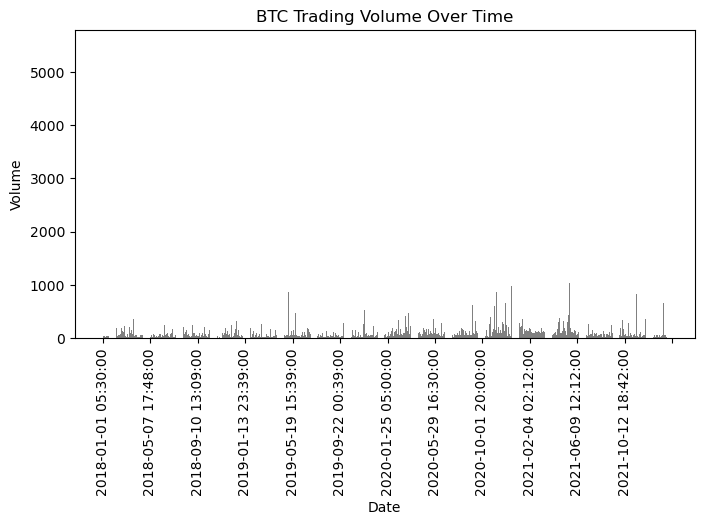

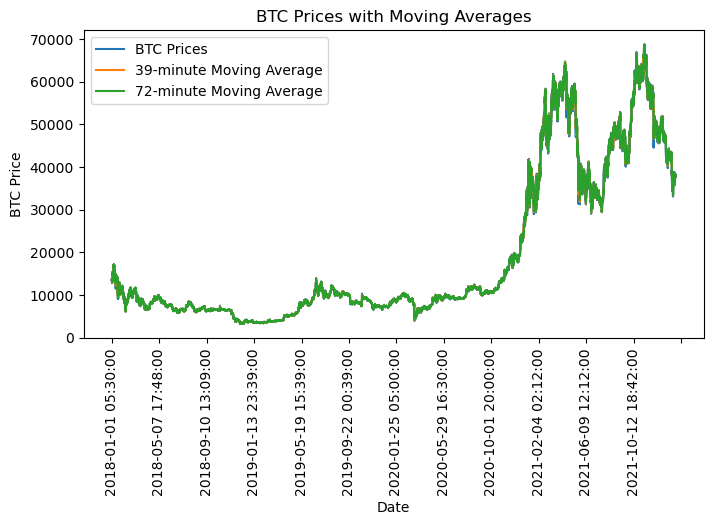

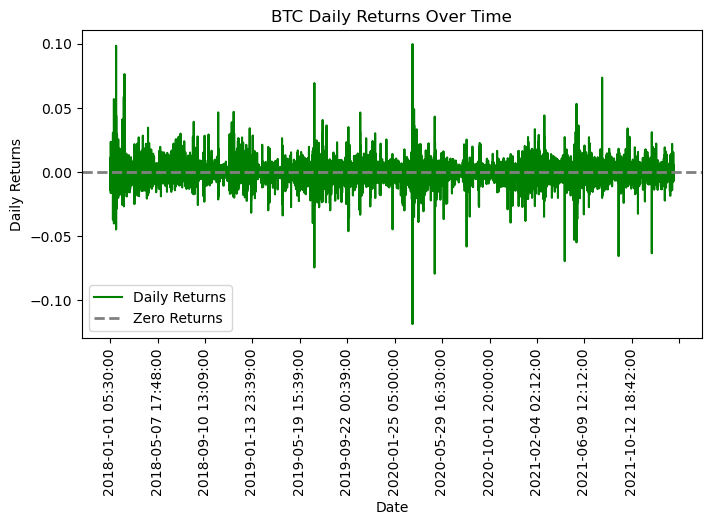

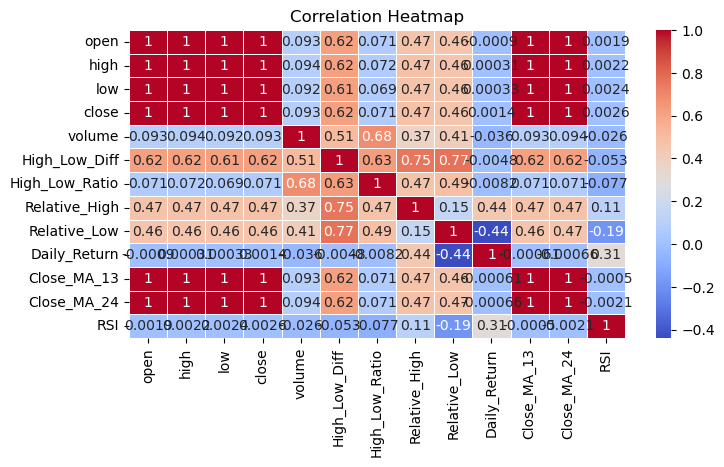

In [4]:
# Volume analysis
plt.figure(figsize=(8, 4))
plt.bar(df.index, df['volume'], color='gray')
plt.title('BTC Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.gca().xaxis.set_major_locator(MultipleLocator(base=60000))
plt.xticks(rotation='vertical')
plt.show()

# Moving Averages
plt.figure(figsize=(8, 4))
plt.plot(df.index, df['close'], label='BTC Prices')
plt.plot(df.index, df['Close_MA_13'], label='39-minute Moving Average')
plt.plot(df.index, df['Close_MA_24'], label='72-minute Moving Average')
plt.title('BTC Prices with Moving Averages')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.gca().xaxis.set_major_locator(MultipleLocator(base=60000))
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

# Returns Analysis
plt.figure(figsize=(8, 4))
plt.plot(df.index, df['Daily_Return'], label='Daily Returns', color='green')
plt.title('BTC Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.axhline(0, color='gray', linestyle='--', linewidth=2, label='Zero Returns')
plt.gca().xaxis.set_major_locator(MultipleLocator(base=60000))
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

# Correlation Heatmap
correlation_matrix = df.corr()
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [5]:
# Feature scaling using Min-Max scaling
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[all_features])

# Set the sequence length (number of time steps to look back)
sequence_length = 10

# Create sequences for training
sequences = []
for i in range(len(df_scaled) - sequence_length):
    seq = df_scaled[i:i + sequence_length, :]
    label = df_scaled[i + sequence_length, :]
    sequences.append((seq, label))

# Convert sequences to numpy arrays
X = np.array([seq[0] for seq in sequences])
y = np.array([seq[1] for seq in sequences])

# Split the data into training and testing sets
train_size = int(len(sequences) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [6]:
# Build the LSTM model with Bidirectional layer
model = Sequential()
model.add(Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.4), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(units=64, recurrent_dropout=0.25)))
model.add(Dense(units=X_train.shape[2]))  # Output layer with the same number of features

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Reduce LR on Plateau to adjust for saturation
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

# Train the model
with tf.device('/cpu:0'):
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

Metal device set to: Apple M2
Epoch 1/10
17826/17826 [==============================] - 678s 38ms/step - loss: 7.5178e-05 - val_loss: 1.5375e-04 - lr: 0.0010
Epoch 2/10
17826/17826 [==============================] - 652s 37ms/step - loss: 6.4511e-05 - val_loss: 2.0429e-04 - lr: 0.0010
Epoch 3/10
17826/17826 [==============================] - 663s 37ms/step - loss: 6.3562e-05 - val_loss: 1.4116e-04 - lr: 0.0010
Epoch 4/10
17826/17826 [==============================] - 693s 39ms/step - loss: 6.2785e-05 - val_loss: 1.5142e-04 - lr: 0.0010
Epoch 5/10
17826/17826 [==============================] - 698s 39ms/step - loss: 6.0571e-05 - val_loss: 1.3587e-04 - lr: 2.0000e-04
Epoch 6/10
17826/17826 [==============================] - 706s 40ms/step - loss: 6.0501e-05 - val_loss: 1.3691e-04 - lr: 2.0000e-04
Epoch 7/10
17826/17826 [==============================] - 724s 41ms/step - loss: 6.0476e-05 - val_loss: 1.3592e-04 - lr: 2.0000e-04
Epoch 8/10
17826/17826 [==============================] - 828s

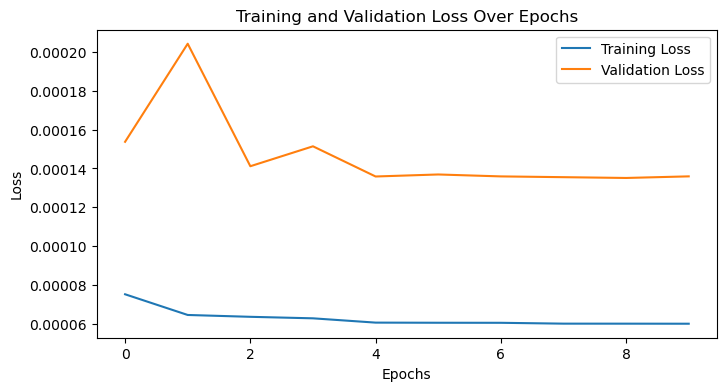

4457/4457 [==============================] - 72s 16ms/step


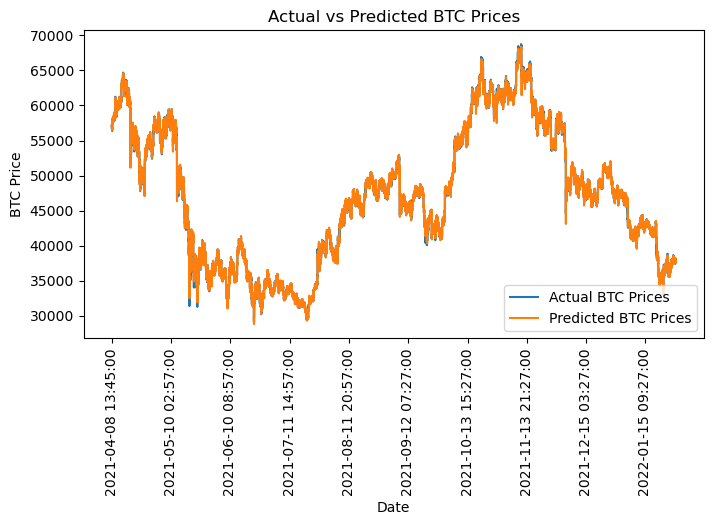

Mean Absolute Percentage Error (MAPE) on Test Closing Price: 0.19%


In [7]:
# Plot training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make predictions on test data
with tf.device('/cpu:0'):
    y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values to get actual prices
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test)

# Plot the predicted and actual trends
plt.figure(figsize=(8, 4))
plt.plot(df.index[train_size + sequence_length:], y_test_actual[:, 3], label='Actual BTC Prices')
plt.plot(df.index[train_size + sequence_length:], y_pred_actual[:, 3], label='Predicted BTC Prices')
plt.title('Actual vs Predicted BTC Prices')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.gca().xaxis.set_major_locator(MultipleLocator(base=15000))
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

# Calculate the mean MAPE for the test closing price
epsilon = 1e-8
mape_mean = np.mean(np.abs((y_pred_actual[:, 3] - y_test_actual[:, 3]) / (y_test_actual[:, 3] + epsilon)) * 100)
print(f'Mean Absolute Percentage Error (MAPE) on Test Closing Price: {mape_mean:.2f}%')

/var/folders/2f/pzwbhzcs2xn32pdvj29ch_880000gn/T/ipykernel_2421/2347731239.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_df['signal'][predicted_df['predicted_Close_MA_13'] > predicted_df['predicted_Close_MA_24']] = 1  # Buy signal
/var/folders/2f/pzwbhzcs2xn32pdvj29ch_880000gn/T/ipykernel_2421/2347731239.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_df['signal'][predicted_df['predicted_Close_MA_13'] < predicted_df['predicted_Close_MA_24']] = -1  # Sell signal
/var/folders/2f/pzwbhzcs2xn32pdvj29ch_880000gn/T/ipykernel_2421/2347731239.py:20: SettingWithCopyWarning: 
A value is trying to 

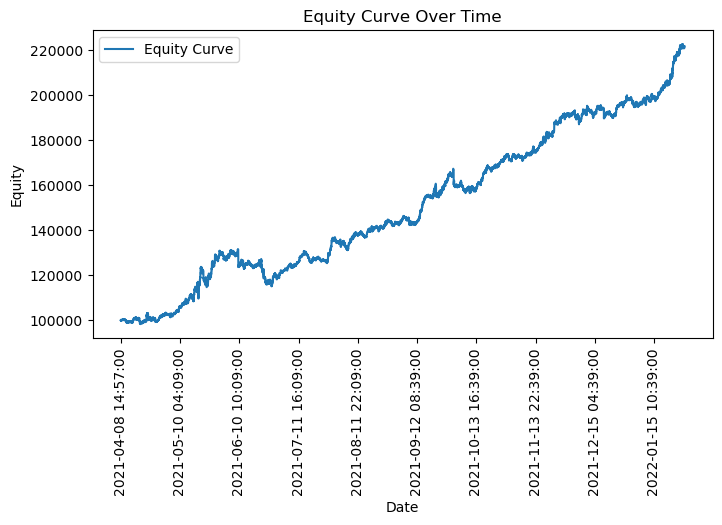

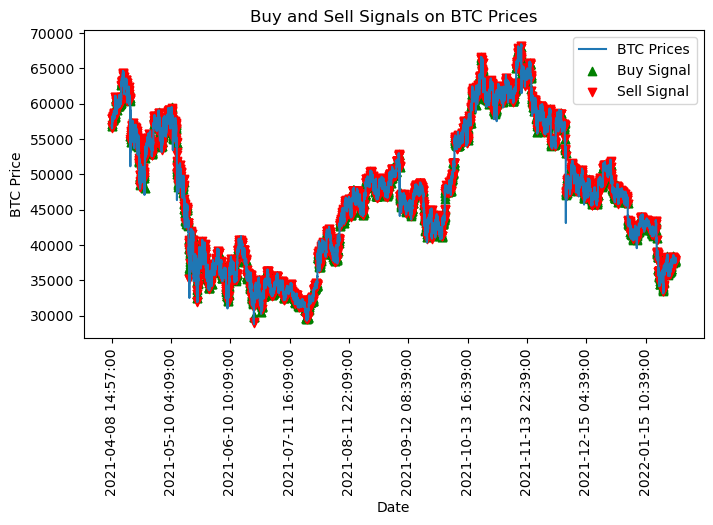

In [8]:
# Extract the datetime index from the original DataFrame
date_index = df.index[train_size + sequence_length:]

# Create a new DataFrame with the predicted closing prices and the original datetime index
predicted_df = pd.DataFrame(data={'predicted_close': y_pred_actual[:, 3]}, index=date_index)

# Replace placeholders and customize according to your strategy
predicted_df['predicted_Close_MA_13'] = predicted_df['predicted_close'].rolling(window=13).mean()
predicted_df['predicted_Close_MA_24'] = predicted_df['predicted_close'].rolling(window=24).mean()
predicted_df = predicted_df.iloc[24:]
stop_loss_percentage = 0.02
risk_reward_ratio = 2
predicted_df['stop_loss'] = predicted_df['predicted_close'] * (1 - stop_loss_percentage)
predicted_df['take_profit'] = predicted_df['predicted_close'] * (1 + risk_reward_ratio * stop_loss_percentage)

# Generate signals based on moving average, stop loss and take profit
predicted_df['signal'] = 0  # Default: Hold
predicted_df['signal'][predicted_df['predicted_Close_MA_13'] > predicted_df['predicted_Close_MA_24']] = 1  # Buy signal
predicted_df['signal'][predicted_df['predicted_Close_MA_13'] < predicted_df['predicted_Close_MA_24']] = -1  # Sell signal
predicted_df['signal'][predicted_df['predicted_close'] < predicted_df['stop_loss']] = -1  # Sell signal (stop loss)
predicted_df['signal'][predicted_df['predicted_close'] > predicted_df['take_profit']] = -1  # Sell signal (take profit)
predicted_df['signal'][(predicted_df['predicted_Close_MA_13'] > predicted_df['predicted_Close_MA_24']) & (predicted_df['predicted_close'] < predicted_df['stop_loss'])] = 1  # Buy signal

flag = 0
sum_signals = 0
modified_signals = []

for _, row in predicted_df.iterrows():
    if flag == -1 and row['signal'] == 1:
        flag = 0
        sum_signals += row['signal']
        modified_signals.append(row['signal'])
        continue
                
    if flag == 1 and row['signal'] == -1:
        flag = 0
        sum_signals += row['signal']
        modified_signals.append(row['signal'])
        continue
            
    if flag == 0 and row['signal'] == 1:
        flag = 1
        sum_signals += row['signal']
        modified_signals.append(row['signal'])
        continue
                
    if flag == 0 and row['signal'] == -1:
        flag = -1
        sum_signals += row['signal']
        modified_signals.append(row['signal'])
        continue
                
    if flag:
        modified_signals.append(0)
    else:
        modified_signals.append(row['signal'])

if sum_signals:
    modified_signals[-1] = sum_signals * -1

# Update the DataFrame with the modified signals
predicted_df['signal'] = modified_signals

# Backtesting Results

# Calculate daily returns based on trade signals
predicted_df['daily_returns'] = predicted_df['predicted_close'].pct_change() * predicted_df['signal'].shift(1)

# Calculate cumulative returns and equity curve
predicted_df['cumulative_returns'] = (1 + predicted_df['daily_returns']).cumprod()
predicted_df['equity_curve'] = 100000 * predicted_df['cumulative_returns']

# Performance Metrics
sharpe_ratio = predicted_df['daily_returns'].mean() / predicted_df['daily_returns'].std() * np.sqrt(252)
annualized_returns = (predicted_df['cumulative_returns'].iloc[-1]) ** (252 / len(predicted_df['predicted_close'])) - 1
max_drawdown = (1 - predicted_df['cumulative_returns'] / predicted_df['cumulative_returns'].cummax()).max()

# Visualizations
plt.figure(figsize=(8, 4))
plt.plot(predicted_df.index, predicted_df['equity_curve'], label='Equity Curve')
plt.title('Equity Curve Over Time')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.gca().xaxis.set_major_locator(MultipleLocator(base=15000))
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

# Trade History
buy_signals = predicted_df[predicted_df['signal'] == 1]
sell_signals = predicted_df[predicted_df['signal'] == -1]

# Plot buy and sell signals on the price chart
plt.figure(figsize=(8, 4))
plt.plot(predicted_df.index, predicted_df['predicted_close'], label='BTC Prices')
plt.scatter(buy_signals.index, buy_signals['predicted_close'], marker='^', color='g', label='Buy Signal')
plt.scatter(sell_signals.index, sell_signals['predicted_close'], marker='v', color='r', label='Sell Signal')
plt.title('Buy and Sell Signals on BTC Prices')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.gca().xaxis.set_major_locator(MultipleLocator(base=15000))
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

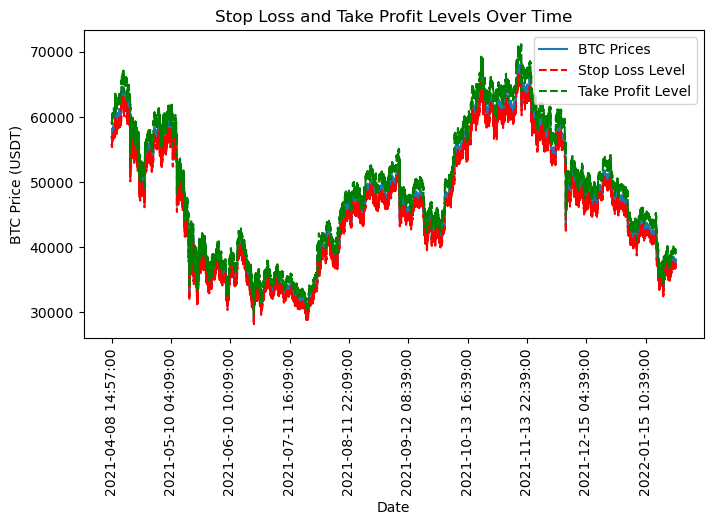

Sharpe Ratio: 0.1725
Annualized Returns: 0.0014
Maximum Drawdown: 0.1248


In [9]:
# Risk Management Plan
# Replace placeholders with actual risk management rules
stop_loss_percentage = 0.02  # Example: 2% stop-loss
risk_reward_ratio = 2  # Example: 2:1 risk-reward ratio

# Calculate stop-loss and take-profit levels
predicted_df['stop_loss'] = predicted_df['predicted_close'] * (1 - stop_loss_percentage)
predicted_df['take_profit'] = predicted_df['predicted_close'] * (1 + risk_reward_ratio * stop_loss_percentage)

# Visualize stop-loss and take-profit levels
plt.figure(figsize=(8, 4))
plt.plot(predicted_df.index, predicted_df['predicted_close'], label='BTC Prices')
plt.plot(predicted_df.index, predicted_df['stop_loss'], label='Stop Loss Level', linestyle='--', color='r')
plt.plot(predicted_df.index, predicted_df['take_profit'], label='Take Profit Level', linestyle='--', color='g')
plt.title('Stop Loss and Take Profit Levels Over Time')
plt.xlabel('Date')
plt.ylabel('BTC Price (USDT)')
plt.gca().xaxis.set_major_locator(MultipleLocator(base=15000))
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

# Print Performance Metrics
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Annualized Returns: {annualized_returns:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.4f}")

# LSTM Model Class

In [ ]:
class LSTM_Model:
    def __init__(self, data_file, sequence_length, train_size):
        self.df = pd.read_csv(data_file, parse_dates=['datetime'], dayfirst=True)
        self.df = self.df.set_index('datetime')
        self.sequence_length = sequence_length
        self.train_size = int(len(self.df) * train_size)
        self.additional_features = ['High_Low_Diff', 'High_Low_Ratio', 'Relative_High', 'Relative_Low']
        self.all_features = ['open', 'high', 'low', 'close', 'volume'] + self.additional_features
        self.scaler = MinMaxScaler()
        self.df_scaled = self.feature_engineering()
        self.model = self.build_model()
        self.y_pred_actual = None

    def feature_engineering(self):
        self.df['High_Low_Diff'] = self.df['high'] - self.df['low']
        self.df['High_Low_Ratio'] = self.df['high'] / self.df['low']
        self.df['Relative_High'] = self.df['high'] - self.df['open']
        self.df['Relative_Low'] = self.df['open'] - self.df['low']
        self.df['Daily_Return'] = self.df['close'].pct_change()
        self.df['Close_MA_13'] = self.df['close'].rolling(window=13).mean()
        self.df['Close_MA_24'] = self.df['close'].rolling(window=24).mean()
        rsi_indicator = RSIIndicator(self.df['close'], window=14)
        self.df['RSI'] = rsi_indicator.rsi()
        df_scaled = self.scaler.fit_transform(self.df[self.all_features])
        return df_scaled

    def volume_analysis(self):
        plt.figure(figsize=(8, 4))
        plt.bar(self.df.index, self.df['volume'], color='gray')
        plt.title('BTC Trading Volume Over Time')
        plt.xlabel('Date')
        plt.ylabel('Volume')
        plt.gca().xaxis.set_major_locator(MultipleLocator(base=60000))
        plt.xticks(rotation='vertical')
        plt.show()

    def moving_averages(self):
        plt.figure(figsize=(8, 4))
        plt.plot(self.df.index, self.df['close'], label='BTC Prices')
        plt.plot(self.df.index, self.df['Close_MA_13'], label='39-minute Moving Average')
        plt.plot(self.df.index, self.df['Close_MA_24'], label='72-minute Moving Average')
        plt.title('BTC Prices with Moving Averages')
        plt.xlabel('Date')
        plt.ylabel('BTC Price')
        plt.gca().xaxis.set_major_locator(MultipleLocator(base=60000))
        plt.xticks(rotation='vertical')
        plt.legend()
        plt.show()

    def return_analysis(self):
        plt.figure(figsize=(8, 4))
        plt.plot(self.df.index, self.df['Daily_Return'], label='Daily Returns', color='green')
        plt.title('BTC Daily Returns Over Time')
        plt.xlabel('Date')
        plt.ylabel('Daily Returns')
        plt.axhline(0, color='gray', linestyle='--', linewidth=2, label='Zero Returns')
        plt.gca().xaxis.set_major_locator(MultipleLocator(base=60000))
        plt.xticks(rotation='vertical')
        plt.legend()
        plt.show()

    def correlation_heatmap(self):
        correlation_matrix = self.df.corr()
        plt.figure(figsize=(8, 4))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
        plt.title('Correlation Heatmap')
        plt.show()

    def build_model(self):
        model = Sequential()
        model.add(Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.4),
                                input_shape=(self.sequence_length, len(self.all_features))))
        model.add(Bidirectional(LSTM(units=64, recurrent_dropout=0.25)))
        model.add(Dense(units=len(self.all_features)))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    def train_model(self, epochs=10, batch_size=32):
        X, y = self.prepare_data_for_training()
        X_train, y_train = X[:self.train_size], y[:self.train_size]
        X_test, y_test = X[self.train_size:], y[self.train_size:]
        early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)
        with tf.device('/cpu:0'):
            history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test),
                                 callbacks=[early_stopping, reduce_lr])
        self.plot_training_history(history)

    def prepare_data_for_training(self):
        sequences = []
        for i in range(len(self.df_scaled) - self.sequence_length):
            seq = self.df_scaled[i:i + self.sequence_length, :]
            label = self.df_scaled[i + self.sequence_length, :]
            sequences.append((seq, label))
        X = np.array([seq[0] for seq in sequences])
        y = np.array([seq[1] for seq in sequences])
        return X, y

    def plot_training_history(self, history):
        plt.figure(figsize=(8, 4))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def make_predictions(self):
        X, y = self.prepare_data_for_training()
        X_test, y_test = X[self.train_size:], y[self.train_size:]
        with tf.device('/cpu:0'):
            y_pred = self.model.predict(X_test)
        self.y_pred_actual = self.scaler.inverse_transform(y_pred)
        y_test_actual = self.scaler.inverse_transform(y_test)
        self.plot_predictions(y_test_actual)

    def plot_predictions(self, y_test_actual):
        plt.figure(figsize=(8, 4))
        plt.plot(self.df.index[self.train_size + self.sequence_length:], y_test_actual[:, 3], label='Actual BTC Prices')
        plt.plot(self.df.index[self.train_size + self.sequence_length:], self.y_pred_actual[:, 3], label='Predicted BTC Prices')
        plt.title('Actual vs Predicted BTC Prices')
        plt.xlabel('Date')
        plt.ylabel('BTC Price')
        plt.gca().xaxis.set_major_locator(MultipleLocator(base=15000))
        plt.xticks(rotation='vertical')
        plt.legend()
        plt.show()
        epsilon = 1e-8
        mape_mean = np.mean(np.abs((self.y_pred_actual[:, 3] - y_test_actual[:, 3]) / (y_test_actual[:, 3] + epsilon)) * 100)
        print(f'Mean Absolute Percentage Error (MAPE) on Test Closing Price: {mape_mean:.2f}%')

    def prepare_data_for_backtesting(self):
        date_index = self.df.index[self.train_size + self.sequence_length:]
        predicted_df = pd.DataFrame(data={'predicted_close': self.y_pred_actual[:, 3]}, index=date_index)
        predicted_df['predicted_Close_MA_13'] = predicted_df['predicted_close'].rolling(window=13).mean()
        predicted_df['predicted_Close_MA_24'] = predicted_df['predicted_close'].rolling(window=24).mean()
        predicted_df = predicted_df.iloc[24:]
        stop_loss_percentage = 0.02
        risk_reward_ratio = 2
        predicted_df['stop_loss'] = predicted_df['predicted_close'] * (1 - stop_loss_percentage)
        predicted_df['take_profit'] = predicted_df['predicted_close'] * (1 + risk_reward_ratio * stop_loss_percentage)
        predicted_df['signal'] = 0  # Default: Hold
        predicted_df['signal'][predicted_df['predicted_Close_MA_13'] > predicted_df['predicted_Close_MA_24']] = 1  # Buy signal
        predicted_df['signal'][predicted_df['predicted_Close_MA_13'] < predicted_df['predicted_Close_MA_24']] = -1  # Sell signal
        predicted_df['signal'][predicted_df['predicted_close'] < predicted_df['stop_loss']] = -1  # Sell signal (stop loss)
        predicted_df['signal'][predicted_df['predicted_close'] > predicted_df['take_profit']] = -1  # Sell signal (take profit)
        predicted_df['signal'][(predicted_df['predicted_Close_MA_13'] > predicted_df['predicted_Close_MA_24']) & (predicted_df['predicted_close'] < predicted_df['stop_loss'])] = 1  # Buy signal
        flag = 0
        sum_signals = 0
        modified_signals = []
        for _, row in predicted_df.iterrows():
            if flag == -1 and row['signal'] == 1:
                flag = 0
                sum_signals += row['signal']
                modified_signals.append(row['signal'])
                continue           
            if flag == 1 and row['signal'] == -1:
                flag = 0
                sum_signals += row['signal']
                modified_signals.append(row['signal'])
                continue      
            if flag == 0 and row['signal'] == 1:
                flag = 1
                sum_signals += row['signal']
                modified_signals.append(row['signal'])
                continue      
            if flag == 0 and row['signal'] == -1:
                flag = -1
                sum_signals += row['signal']
                modified_signals.append(row['signal'])
                continue     
            if flag:
                modified_signals.append(0)
            else:
                modified_signals.append(row['signal'])
        if sum_signals:
            modified_signals[-1] = sum_signals * -1
        predicted_df['signal'] = modified_signals
        return predicted_df

    def backtesting(self):
        predicted_df = self.prepare_data_for_backtesting()
        predicted_df['daily_returns'] = predicted_df['predicted_close'].pct_change() * predicted_df['signal'].shift(1)
        predicted_df['cumulative_returns'] = (1 + predicted_df['daily_returns']).cumprod()
        predicted_df['equity_curve'] = 100000 * predicted_df['cumulative_returns']
        self.backtesting_visualizations(predicted_df)
    
    def backtesting_visualizations(self, predicted_df):
        plt.figure(figsize=(8, 4))
        plt.plot(predicted_df.index, predicted_df['equity_curve'], label='Equity Curve')
        plt.title('Equity Curve Over Time')
        plt.xlabel('Date')
        plt.ylabel('Equity')
        plt.gca().xaxis.set_major_locator(MultipleLocator(base=15000))
        plt.xticks(rotation='vertical')
        plt.legend()
        plt.show()
        buy_signals = predicted_df[predicted_df['signal'] == 1]
        sell_signals = predicted_df[predicted_df['signal'] == -1]
        plt.figure(figsize=(8, 4))
        plt.plot(predicted_df.index, predicted_df['predicted_close'], label='BTC Prices')
        plt.scatter(buy_signals.index, buy_signals['predicted_close'], marker='^', color='g', label='Buy Signal')
        plt.scatter(sell_signals.index, sell_signals['predicted_close'], marker='v', color='r', label='Sell Signal')
        plt.title('Buy and Sell Signals on BTC Prices')
        plt.xlabel('Date')
        plt.ylabel('BTC Price')
        plt.gca().xaxis.set_major_locator(MultipleLocator(base=15000))
        plt.xticks(rotation='vertical')
        plt.legend()
        plt.show()

    def risk_management(self):
        predicted_df = self.prepare_data_for_backtesting()
        predicted_df['daily_returns'] = predicted_df['predicted_close'].pct_change() * predicted_df['signal'].shift(1)
        predicted_df['cumulative_returns'] = (1 + predicted_df['daily_returns']).cumprod()
        stop_loss_percentage = 0.02
        risk_reward_ratio = 2
        predicted_df['stop_loss'] = predicted_df['predicted_close'] * (1 - stop_loss_percentage)
        predicted_df['take_profit'] = predicted_df['predicted_close'] * (1 + risk_reward_ratio * stop_loss_percentage)
        plt.figure(figsize=(8, 4))
        plt.plot(predicted_df.index, predicted_df['predicted_close'], label='BTC Prices')
        plt.plot(predicted_df.index, predicted_df['stop_loss'], label='Stop Loss Level', linestyle='--', color='r')
        plt.plot(predicted_df.index, predicted_df['take_profit'], label='Take Profit Level', linestyle='--', color='g')
        plt.title('Stop Loss and Take Profit Levels Over Time')
        plt.xlabel('Date')
        plt.ylabel('BTC Price (USDT)')
        plt.gca().xaxis.set_major_locator(MultipleLocator(base=15000))
        plt.xticks(rotation='vertical')
        plt.legend()
        plt.show()
        self.performance_metrics(predicted_df)

    def performance_metrics(self, predicted_df):
        sharpe_ratio = predicted_df['daily_returns'].mean() / predicted_df['daily_returns'].std() * np.sqrt(252)
        annualized_returns = (predicted_df['cumulative_returns'].iloc[-1]) ** (252 / len(predicted_df['predicted_close'])) - 1
        max_drawdown = (1 - predicted_df['cumulative_returns'] / predicted_df['cumulative_returns'].cummax()).max()
        print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
        print(f"Annualized Returns: {annualized_returns:.4f}")
        print(f"Maximum Drawdown: {max_drawdown:.4f}")

lstm_model = LSTM_Model(data_file='btc_3m.csv', sequence_length=10, train_size=0.8)
lstm_model.volume_analysis()
lstm_model.moving_averages()
lstm_model.return_analysis()
lstm_model.correlation_heatmap()
lstm_model.train_model(epochs=10, batch_size=32)
lstm_model.make_predictions()
lstm_model.backtesting()
lstm_model.risk_management()